In [1]:
!pip install --upgrade pip
!pip install python-decouple
!pip install geoalchemy2
!pip install shapely
!pip install scipy
!pip install hyperas

Requirement already up-to-date: pip in /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (19.1.1)


In [2]:
from sqlalchemy import create_engine, func, text
from sqlalchemy.orm import sessionmaker
from decouple import config
from shapely import wkb, wkt
from shapely.geometry import Point
from geoalchemy2.shape import to_shape 

import pandas as pd
import numpy as np
import json
from datetime import datetime, timedelta
import re
from matplotlib import pyplot as plt
import random

from sklearn.preprocessing import RobustScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import GridSearchCV

from hyperas.distributions import uniform



# ----------- TODO: Issues with importing imbalance-learn library
# from imblearn.over_sampling import RandomOverSampler
# from imblearn.under_sampling import NearMiss
# from imblearn.under_sampling import (RandomUnderSampler,
#                                      ClusterCentroids,
#                                      TomekLinks,
#                                      NeighbourhoodCleaningRule,
#                                      NearMiss)

Using TensorFlow backend.


In [3]:
"""Contains models for DB."""

from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, BigInteger, Integer, String, DateTime, ForeignKey, Float
from sqlalchemy.orm import relationship
from geoalchemy2 import Geometry


BASE = declarative_base()


class City(BASE):
    """City model for DB. Has information of cities."""
    __tablename__ = 'city'
    id            = Column(BigInteger, primary_key=True)
    city          = Column(String, unique=False, nullable=False)
    state         = Column(String, unique=False, nullable=True)
    country       = Column(String, unique=False, nullable=False)
    location      = Column(Geometry(geometry_type='POINT'), nullable=False)
    blocks        = relationship("Blocks", back_populates="city")
    zipcodes      = relationship("ZipcodeGeom", back_populates="city")
    incidents     = relationship("Incident", back_populates="city")


class Blocks(BASE):
    """Block model for DB. Has information of city blocks for a related city
        id."""
    __tablename__ = 'block'
    id            = Column(BigInteger, primary_key=True)
    cityid        = Column(BigInteger, ForeignKey('city.id'), nullable=False)
    shape         = Column(Geometry(geometry_type='MULTIPOLYGON'), nullable=False)
    population    = Column(Integer, nullable=False)
    city          = relationship("City", back_populates="blocks")
    incidents     = relationship("Incident", back_populates="block")

class ZipcodeGeom(BASE):
    """Zipcode geometry model for DB. Has information of zipcodes and related
        city id."""
    __tablename__ = 'zipcodegeom'
    id            = Column(BigInteger, primary_key=True)
    cityid        = Column(BigInteger, ForeignKey('city.id'), nullable=False)
    zipcode       = Column(String, nullable=False, unique=True)
    shape         = Column(Geometry(geometry_type='MULTIPOLYGON'), nullable=False)
    city          = relationship("City", back_populates="zipcodes")

class Incident(BASE):
    """Incident model for DB. Has information of a specific crime, including
        where it took place, when it took place, and the type of crime that
        occurred."""
    __tablename__ = 'incident'
    id            = Column(BigInteger, primary_key=True)
    crimetypeid   = Column(BigInteger, ForeignKey('crimetype.id'), nullable=False)
    locdescid     = Column(BigInteger, ForeignKey('locdesctype.id'), nullable=False)
    cityid        = Column(BigInteger, ForeignKey('city.id'), nullable=False)
    blockid       = Column(BigInteger, ForeignKey('block.id'), nullable=False)
    location      = Column(Geometry(geometry_type='POINT'), nullable=False)
    datetime      = Column(DateTime, nullable=False)
    hour          = Column(Integer, nullable=False)
    dow           = Column(Integer, nullable=False)
    month         = Column(Integer, nullable=False)
    year          = Column(Integer, nullable=False)
    city          = relationship("City", back_populates="incidents")
    block         = relationship("Blocks", back_populates="incidents")
    crimetype     = relationship("CrimeType", back_populates="incidents")
    locationdesc  = relationship("LocationDescriptionType", back_populates="incidents")

class CrimeType(BASE):
    """CrimeType model for DB. Has information of the types of crime, including
        a general description and the numerical severity of the crime."""
    __tablename__ = 'crimetype'
    id            = Column(BigInteger, primary_key=True)
    category      = Column(String, unique=True, nullable=False)
    severity      = Column(Integer, nullable=False)
    incidents     = relationship("Incident", back_populates="crimetype")


class LocationDescriptionType(BASE):
    """Location description model for DB. Has information on the type of
        location that the crime took place."""
    __tablename__ = 'locdesctype'
    id            = Column(BigInteger, primary_key=True)
    key1          = Column(String, nullable=False)
    key2          = Column(String, nullable=False)
    key3          = Column(String, nullable=False)
    incidents     = relationship("Incident", back_populates="locationdesc")

In [4]:
class GetData(object):
    def go(self, SESSION, start_year, end_year):
        SQL_QUERY = \
            f'''
                WITH
                    max_severity AS (
                        SELECT MAX(severity) AS severity
                        FROM (
                            SELECT SUM(crimetype.severity)/AVG(block.population) AS severity
                            FROM incident
                            INNER JOIN block ON incident.blockid = block.id INNER JOIN crimetype ON incident.crimetypeid = crimetype.id AND block.population > 0
                            GROUP BY
                                incident.blockid,
                                incident.year,
                                incident.month,
                                incident.dow
                        ) AS categories
                    ),
                    block_incidents AS (
                        SELECT
                            incident.blockid,
                            incident.year,
                            incident.month,
                            incident.dow,
                            SUM(crimetype.severity)/AVG(block.population) AS severity
                        FROM incident
                        INNER JOIN block ON incident.blockid = block.id
                        INNER JOIN crimetype ON incident.crimetypeid = crimetype.id
                            AND block.population > 0
                            AND incident.cityid = 1
                            AND incident.year >= {start_year}
                            AND incident.year <= {end_year}
                        GROUP BY
                            incident.blockid,
                            incident.year,
                            incident.month,
                            incident.dow
                    )
                SELECT
                    block_incidents.blockid,
                    block_incidents.year,
                    block_incidents.month,
                    block_incidents.dow,
                    block_incidents.severity/max_severity.severity AS severity
                FROM block_incidents, max_severity        
            '''
        return SESSION.execute(text(SQL_QUERY)).fetchall()

In [5]:
def process_data(data, start_year, end_year, blockid_dict):

    X = np.zeros((len(blockid_dict), 24, 7))
    y = np.zeros((len(blockid_dict), 12, 7))
    
    # records is the list of rows we get from the query with this order:
    #   blockid, year, month, dow, hour, risk
    #   month is from 1 - 12

    for r in data:
        if r[0] in blockid_dict:
            if r[1] == end_year:
                # index into array  0-based month
                # vvvvvvvvvvvvvvvv    vvvvvv
                y[blockid_dict[r[0]], r[2]-1, r[3]] = float(r[4])
                #                             ^^^^^^^^^^^^^   ^^^^
                #                             hours since     risk
                #                             beginning of
                #                             week
            else:
                # month, year = get_month_year(datetime)
                # index into array    year 0.....1   month   
                # vvvvvvvvvvvvvvvv    vvvvvvvvvvvvv  vvvvvv
                X[blockid_dict[r[0]], 12*(r[1]-start_year)+r[2]-1, r[3]] = float(r[4])
                #                                                  ^^^^^^^^^^^^^   ^^^^
                #                                                  hours since     risk
                #                                                  beginning of
                #                                                  week


    X = X * 1000
    y = y * 1000

    #     for i in range(24):
    #         X[:, i, -1] = (start_year*12+i) / (2000 * 12)
        
    return X, y

In [6]:
from contextlib import contextmanager

@contextmanager
def session_scope():
    """Provide a transactional scope around a series of operations."""

    DB_URI  = config('DB_URI')
    ENGINE  = create_engine(DB_URI)
    Session = sessionmaker(bind=ENGINE)
    SESSION = Session()
    
    try:
        yield SESSION
        SESSION.commit()
    except:
        SESSION.rollback()
        raise
    finally:
        SESSION.close()


def ready_data(training_start_year, training_end_year, train_blockid_dict,
               testing_start_year, testing_end_year, test_blockid_dict):
    with session_scope() as session:
        training_data = GetData().go(session,
                                     training_start_year,
                                     training_end_year)
        testing_data = GetData().go(session,
                                     testing_start_year,
                                     testing_end_year)
        
        X_train, y_train = process_data(training_data,
                                        training_start_year, 
                                        training_end_year,
                                        train_blockid_dict)
        X_test, y_test = process_data(testing_data,
                                      testing_start_year, 
                                      testing_end_year,
                                      test_blockid_dict)

    return X_train, X_test, y_train, y_test

In [9]:
%%time

# start month = 3, end_month = 2 (months are 0-indexed)
#   X: 4/2017 -> 3/2019 actual date
#   y: 4/2019 -> 3/2020 actual date
#
X_test_start_month = 0
X_test_end_month   = 0
X_test_start_year  = 2016
X_test_end_year    = 2018

TRAIN_NUM_BLOCKIDS = TEST_NUM_BLOCKIDS = 800

TRAIN_BLOCKIDS = random.sample(list(range(1,802)), k=TRAIN_NUM_BLOCKIDS)   
train_blockid_dict = {}
for ind, blockid in enumerate(TRAIN_BLOCKIDS ):
    train_blockid_dict[blockid] = ind
        
TEST_BLOCKIDS = random.sample(list(range(1,802)), k=TEST_NUM_BLOCKIDS)    
test_blockid_dict = {}
for ind, blockid in enumerate(TEST_BLOCKIDS ):
    test_blockid_dict[blockid] = ind

X_train, X_test, y_train, y_test = ready_data(2015, 2017, train_blockid_dict,
                                              X_test_start_year, X_test_end_year, test_blockid_dict)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


(800, 24, 7) (800, 12, 7) (800, 24, 7) (800, 12, 7)
CPU times: user 1.74 s, sys: 59 ms, total: 1.8 s
Wall time: 24.4 s


In [10]:
x_flat = X_test.flatten()
len(x_flat[x_flat > 0.0])

117609

In [11]:
len(x_flat[x_flat > 0.0])/len(x_flat)

0.8750669642857143

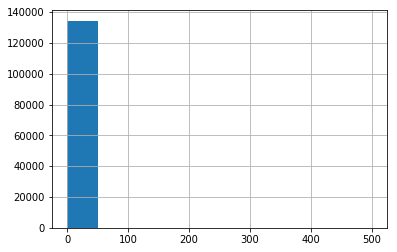

In [52]:
pd.Series(x_flat).hist();

In [13]:
pd.Series(x_flat).value_counts()

0.000000    16791
0.341880      115
0.535906      111
0.647249       99
0.472144       90
0.693001       82
0.464253       81
0.390549       79
1.618123       75
0.366300       74
0.267953       72
1.078749       72
0.857633       72
0.137826       70
0.944287       68
0.599520       66
0.289352       66
0.439754       64
0.582751       64
1.294498       63
0.291121       63
1.307190       62
0.393082       62
0.761035       62
0.416146       61
0.693481       61
0.571755       61
0.401929       60
0.268168       60
0.803859       60
            ...  
3.807418        1
2.367119        1
0.183251        1
3.533677        1
1.359690        1
1.777101        1
3.336068        1
4.423381        1
4.398021        1
3.592814        1
2.336722        1
1.517660        1
1.457372        1
1.789709        1
4.617414        1
3.405370        1
0.691460        1
3.233891        1
1.698420        1
1.544799        1
2.287378        1
1.085019        1
1.022181        1
1.447411        1
0.537792  

In [14]:
np.corrcoef(y_train.flatten(), y_test.flatten())

array([[ 1.        , -0.00529552],
       [-0.00529552,  1.        ]])

In [36]:
X_train = X_train.reshape((800, 168))
y_train = y_train.reshape((800, 84))
X_test = X_test.reshape((800, 168))
y_test = y_test.reshape((800, 84))

In [51]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

model = MultiOutputRegressor(RandomForestRegressor())

# For regressors:
param_grid = {
    #     'n_estimators':  [80, 100, 120, 1000, 3000, 5000, 10000],
    #     'max_depth': [2, 3, 4, 5, 6, 7, 8],
}

# For classifiers:
# param_grid = {
#     'estimator__n_estimators':  [80, 100, 120],
#     'estimator__max_depth': [2, 3, 4, 5, 6, 7, 8],
# }

gridsearch = GridSearchCV(model,
                          param_grid=param_grid, 
                          scoring='neg_mean_squared_error', 
                          cv=3, n_jobs=-1,
                          return_train_score=True, verbose=10)
gridsearch.fit(X_train, y_train)

best_training_score = gridsearch.score(X_train, y_train)
best_testing_score  = gridsearch.score(X_test, y_test)
best_model_params = gridsearch.cv_results_['params'][gridsearch.best_index_]

print(f'  Best training score:', -best_training_score)
print(f'  Best testing score: ', -best_testing_score)
print('Best Grid Search model:', best_model_params)

y_pred = gridsearch.predict(X_test)
print('mean_squared_error:', mean_squared_error(y_test, y_pred))

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   44.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   44.5s finished
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in ve

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in ve

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in ve

  Best training score: 0.9158545043695382
  Best testing score:  3.5345217109404516
Best Grid Search model: {}


In [46]:
def plot_output(y, y_pred, dataset_type):

    fig = plt.figure(figsize=(10, 8))
    plt.plot(np.arange(len(y.flatten())),
                 y.flatten(), color='blue');
    plt.plot(np.arange(len(y_pred.flatten())),
                 y_pred.flatten(), color='red');
    plt.xlabel('Hour since beginning of data', fontsize=16)
    plt.ylabel('Risk', fontsize=18)
    plt.title(dataset_type + ' dataset', fontsize=18)
    plt.legend(labels=['risk', 'predicted risk'], prop={'size': 20})
    plt.show()

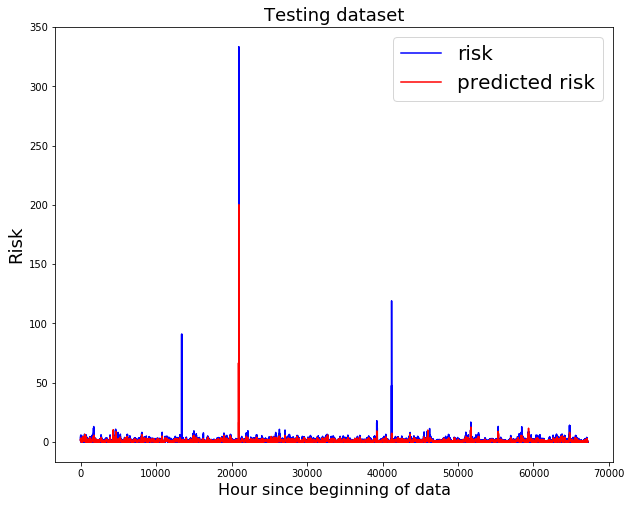

In [48]:
plot_output(y_test, y_pred, 'Testing')